# Получение df из clickhouse с помощью pandahouse и анализ данных

C помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python.

Датасет будет содержать информацию об объявлениях на Airbnb в Лондоне.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах

## Имортируем библиотеки

In [2]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

## Записываем требуемые параметры для функции ph.read_clickhouse(), чтрбы загрузить данные из clickhouse

In [11]:
connection_ldn_listings = {'host': 'http://clickhouse.beslan.pro:8080',
                           'database':'default',
                           'user':'student', 
                           'password':'dpo_python_2020'
                          }

## Task 1

Выгрузите из таблицы данные о цене в зависимости от типа жилья.

Необходимые столбцы:
- price – цена за ночь
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

Пишем запрос и выгружаем данные в датафрейм

In [26]:
# sql запрос - цена в зависимости от типа жилья
q = '''
SELECT
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM 
    ldn_listings
ORDER BY
    id
LIMIT 1000
'''

In [27]:
q_price_room_type = ph.read_clickhouse(query=q, connection=connection_ldn_listings)
q_price_room_type

,id,room_type,price
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0
...,...,...,...
995,541081,Entire home/apt,110.0
996,541363,Entire home/apt,110.0
997,542231,Private room,65.0
998,542646,Entire home/apt,100.0


Начинаем обработку данных

Проверяем тип данных

In [29]:
q_price_room_type.dtypes

id            uint32
room_type     object
price        float32
dtype: object

Проверяем пропущенные значения

In [30]:
q_price_room_type.isna().any()

id           False
room_type    False
price        False
dtype: bool

Проверим наличие дупликатов

In [34]:
q_price_room_type.duplicated().any()

False

In [35]:
q_price_room_type.id.nunique()

1000

Сгруппируем полученный датафрейм по типу жилья и посчитаем 75-й перцентиль цены.

In [38]:
# видим, что для private room значение 75 перцентиля = 70$
q_price_room_type.groupby(['room_type'], as_index=False) \
    .price.quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


# Task 2

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Постройте график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Пишем еще один запрос и загружаем данные в датафрейм

In [41]:
# sql запрос - цена в зависимости от типа жилья
q2 = '''
SELECT
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM 
    ldn_listings
WHERE
    review_scores_rating IS NOT NULL
ORDER BY
    id
LIMIT 1000
'''

In [43]:
q_mean_price = ph.read_clickhouse(query=q2, connection=connection_ldn_listings)
q_mean_price

,id,room_type,price,review_scores_rating
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0
...,...,...,...,...
995,616278,Entire home/apt,165.0,100.0
996,617678,Private room,99.0,93.0
997,618082,Private room,45.0,100.0
998,619010,Private room,20.0,88.0


Считаем средние значения price и rating для room_type, а затем их визуализируем

In [44]:
q_mean_price = q_mean_price \
    .groupby('room_type', as_index=False) \
    .agg({'price':'mean', 'review_scores_rating':'mean'})

In [47]:
q_mean_price

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


Видим, что среднее значение цены для entire home/apt и hotel room выше, а среднее значение рейтинга ниже, чем у private room. Можно сделать вывод, что у людей, которые платят много денег за отель или квартиру, выше ожидания по комфорту, которые иногда не оправдываются. В то время, как среднее значение рейтинга у private room высок, так как у людей скорее всего ожидания занижены + им нужна комната, чтобы переночевать и сэкономить деньги.

<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

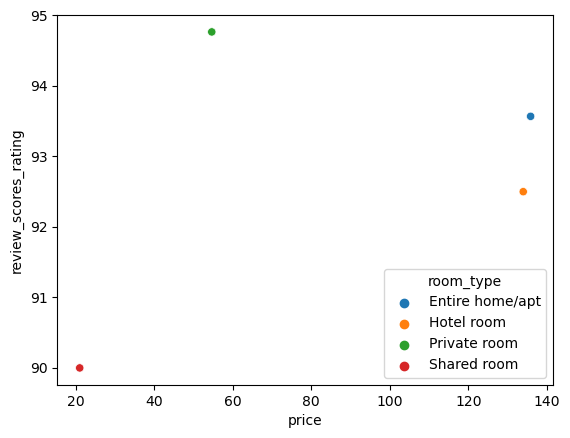

In [46]:
sns.scatterplot(data = q_mean_price, x='price', y='review_scores_rating', hue ='room_type')

# Task 3

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверьте, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none').
Для каждого уникального пользователя выгрузите только две колонки:
- `host_id` – идентификатор хозяина (уникальный)
- `host_verifications` – какими способами хост подтвердил свой профиль

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). \
Приведите их к настоящему списку, где в качестве элементов будут хранится использованные способы подтверждения аккаунта: \
`"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']`

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации. Сколько хозяев подтвердили профиль с помощью аккаунта Google?

Формируем новй запрос и загружаем данные в датафрейм

In [49]:
q3 = '''
SELECT 
    host_id,
    host_verifications
FROM 
    default.ldn_listings
 WHERE
    experiences_offered != 'none'
'''
q_verification = ph.read_clickhouse(query=q3, connection=connection_ldn_listings)
q_verification

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1543,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1544,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."
1545,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."
1546,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."


Приводим данные к списку

In [60]:
q_verification['host_verifications'] = q_verification['host_verifications'].str.strip("[]") \
                                        .str.replace('\'', '').str.split(', ')

In [63]:
q_verification.head()

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."


Проверим наличие дупликатов и уберем их, если есть

In [66]:
q_verification.host_id.duplicated().any()

True

In [67]:
q_verification = q_verification.drop_duplicates(subset='host_id', keep='first')

Считаем, сколько раз встречается каждый способ верификации и сколько хозяев подтвердили профиль с помощью аккаунта Google

In [68]:
q_verification.explode('host_verifications').value_counts(subset='host_verifications')

host_verifications
phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
dtype: int64

34 хозяева подтвердили способ верификации через google

# Task 4

Посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите `experiences_count`.

Отсортируйте данные по убыванию `experiences_count` и выгрузите первые 100 строк. Затем преобразуйте данные с помощью `pivot`, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью `sns.heatmap()` c палитрой `cmap=sns.cubehelix_palette(as_cmap=True)`.

Формируем запрос и загружаем данные в датафрейм

In [69]:
q4 = '''
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    host_verifications
FROM 
    default.ldn_listings
 WHERE
    experiences_offered != 'none'
'''

Преобразуем данные host_verification в список

In [70]:
q_experience = ph.read_clickhouse(query=q4, connection=connection_ldn_listings)
q_experience['host_verifications'] = q_experience['host_verifications'].str.strip("[]") \
                                        .str.replace('\'', '').str.split(', ')
q_experience

,neighbourhood_cleansed,experiences_offered,host_verifications
0,Islington,business,"[email, phone, facebook, reviews, offline_gove..."
1,Kensington and Chelsea,romantic,"[email, phone, reviews, jumio, government_id]"
2,Hammersmith and Fulham,business,"[email, phone, jumio, selfie, government_id, i..."
3,Haringey,business,"[email, phone, manual_offline, jumio, offline_..."
4,Barnet,business,"[email, phone, reviews, offline_government_id,..."
...,...,...,...
1543,Croydon,family,"[email, phone, reviews, jumio, government_id]"
1544,Islington,business,"[email, phone, facebook, jumio, offline_govern..."
1545,Camden,business,"[email, phone, google, reviews, jumio, offline..."
1546,Islington,business,"[email, phone, facebook, jumio, offline_govern..."


Раскроем список

In [71]:
q_experience = q_experience \
    .explode('host_verifications')

In [73]:
q_experience.head()

,neighbourhood_cleansed,experiences_offered,host_verifications
0,Islington,business,email
0,Islington,business,phone
0,Islington,business,facebook
0,Islington,business,reviews
0,Islington,business,offline_government_id


Сгруппируем данные по району и виду впечатления и посчитаем количество объявлений. Отсортируем данные по убыванию experiences_count и выгрузим первые 100 строк.

In [74]:
q_experience = q_experience \
    .groupby(['neighbourhood_cleansed', 'experiences_offered'], as_index = False) \
    .agg({'host_verifications':'count'}) \
    .rename(columns={'host_verifications':'experiences_count'}) \
    .sort_values('experiences_count', ascending=False) \
    .head(100)

In [75]:
q_experience.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
98,Tower Hamlets,business,370
36,Hackney,family,365
109,Westminster,business,311
38,Hackney,social,304
35,Hackney,business,302


Преобразуем данные с помощью pivot

In [76]:
q_experience = q_experience \
                .pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

In [77]:
q_experience.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,13.0
Barnet,37.0,35.0,17.0,26.0
Brent,59.0,129.0,33.0,33.0
Bromley,21.0,11.0,7.0,25.0
Camden,221.0,177.0,113.0,159.0


Визуализируем данные с помощью heatmap

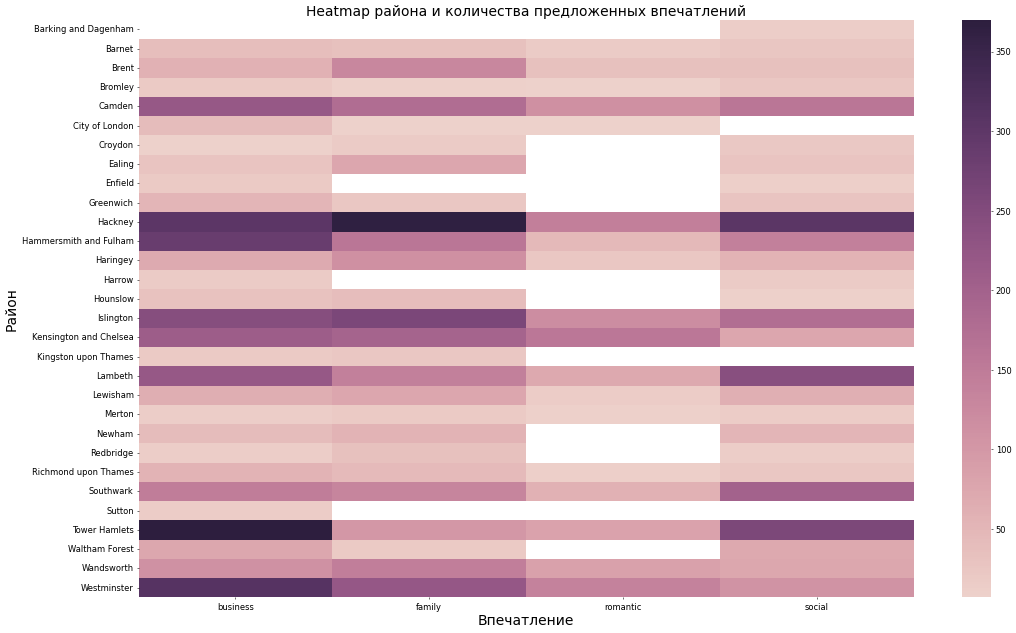

In [147]:
fig=plt.figure(figsize=(25,15), dpi=50)
sns.heatmap(q_experience, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Heatmap района и количества предложенных впечатлений', size=20)
plt.xlabel('Впечатление', size=20)
plt.ylabel('Район', size=20)
plt.rc('axes', labelsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.show()

# Task 5

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:
- room_type – тип сдаваемого жилья
- price – цена за ночь
- experiences_offered – вид доступного впечатления (оставить не 'none')

Далее постройте два графика, используя distplot из библиотеки seaborn:

- На первом отобразите исходные распределения цен для каждого типа жилья
- На втором – логарифмированные значения (np.log())

Формируем запрос, выгружаем данные в датафрейм

In [148]:
q5 = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    experiences_offered
FROM 
    default.ldn_listings
 WHERE
    experiences_offered != 'none'
'''
q_distplot = ph.read_clickhouse(query=q5, connection=connection_ldn_listings)
q_distplot

,room_type,price,experiences_offered
0,Private room,65.0,business
1,Entire home/apt,100.0,romantic
2,Private room,150.0,business
3,Private room,45.0,business
4,Private room,25.0,business
...,...,...,...
1543,Entire home/apt,100.0,family
1544,Entire home/apt,125.0,business
1545,Entire home/apt,185.0,business
1546,Entire home/apt,110.0,business


Строим графики:
- На первом изобразим исходные распределения цен для каждого типа жилья
- На втором изобразим логарифмированные значения (np.log())

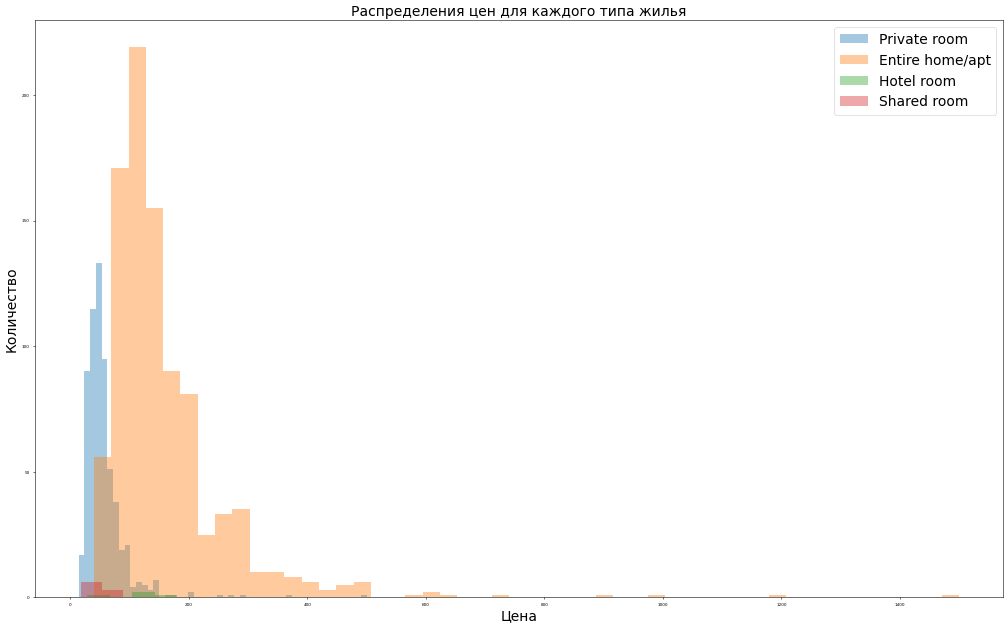

In [150]:
fig=plt.figure(figsize=(25,15), dpi=50)
sns.distplot(q_distplot.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(q_distplot.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(q_distplot.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(q_distplot.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.title('Распределения цен для каждого типа жилья', size=20)
plt.xlabel('Цена', size=20)
plt.ylabel('Количество', size=20)
plt.rc('axes', labelsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.legend()
plt.show()

Прологарифмируем данные для сглаживания. Видим, что распределение стало похоже на нормальное

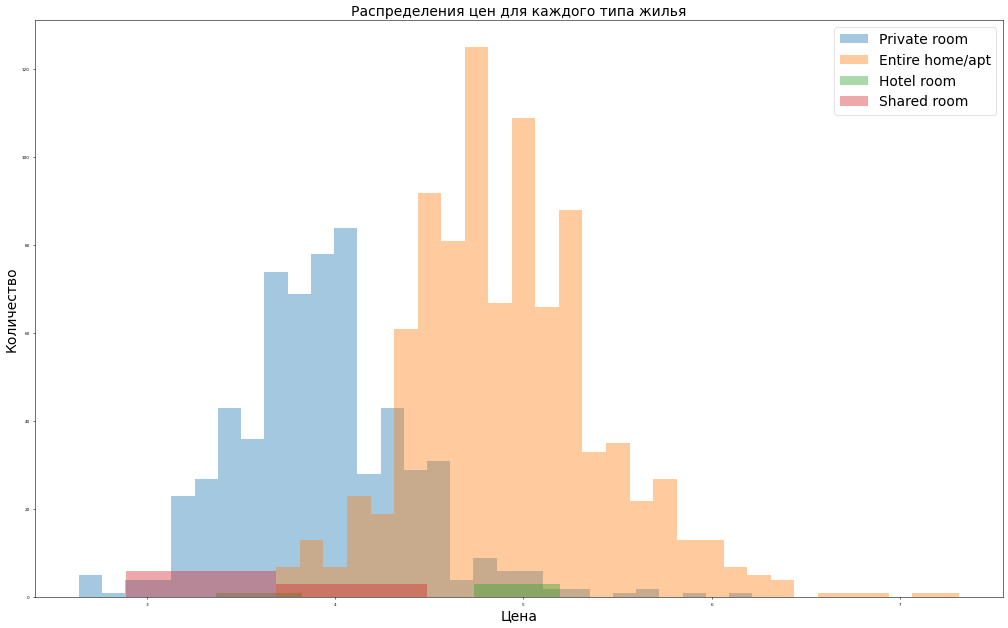

In [153]:
fig=plt.figure(figsize=(25,15), dpi=50)
sns.distplot(np.log(q_distplot.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(q_distplot.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(q_distplot.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(q_distplot.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.title('Распределения цен для каждого типа жилья', size=20)
plt.xlabel('Цена', size=20)
plt.ylabel('Количество', size=20)
plt.rc('axes', labelsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.legend()
plt.show()

# Task 6

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

- `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- `price` – цена за ночь
- `first_review` – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Формируем запрос и загружаем данные в датафрейм

In [167]:
q5 = '''
SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type,
    toDateOrZero(first_review) AS first_review    
FROM 
    default.ldn_listings
 WHERE
    first_review > '2010-01-01'
LIMIT 1000
'''
q_lineplot = ph.read_clickhouse(query=q5, connection=connection_ldn_listings)
q_lineplot

,price,room_type,first_review
0,65.0,Private room,2010-08-18
1,300.0,Entire home/apt,2011-03-21
2,65.0,Entire home/apt,2016-03-05
3,29.0,Private room,2010-04-14
4,100.0,Private room,2010-10-16
...,...,...,...
995,45.0,Private room,2012-11-07
996,51.0,Private room,2013-03-18
997,79.0,Entire home/apt,2012-09-17
998,110.0,Entire home/apt,2012-09-24


In [168]:
q_lineplot.dtypes

price                  float32
room_type               object
first_review    datetime64[ns]
dtype: object

Так как нам нужен год, то извлекаем из даты год. Воспользуемся dt.year, так как всегда применение функции ко всему датафрейму работает быстрее, чем использовать цикл или применять функцию к каждом значению

In [169]:
# q_lineplot['first_review'] = q_lineplot['first_review'].apply(lambda x: x.strftime('%Y-%m-%d').split("-")[0])

In [170]:
q_lineplot['first_review'] = q_lineplot.first_review.dt.year

Для построения графика динамики средних цен на жилье сгруппируем данные по году и типу жилья и найдем среднее значение цены

In [171]:
q_lineplot = q_lineplot \
    .groupby(['first_review', 'room_type'], as_index=False) \
    .agg({'price':'mean'}) \
    .rename(columns={'price':'avg_price'}) \
    .sort_values('first_review')

In [173]:
q_lineplot.head()

,first_review,room_type,avg_price
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143


Строим график

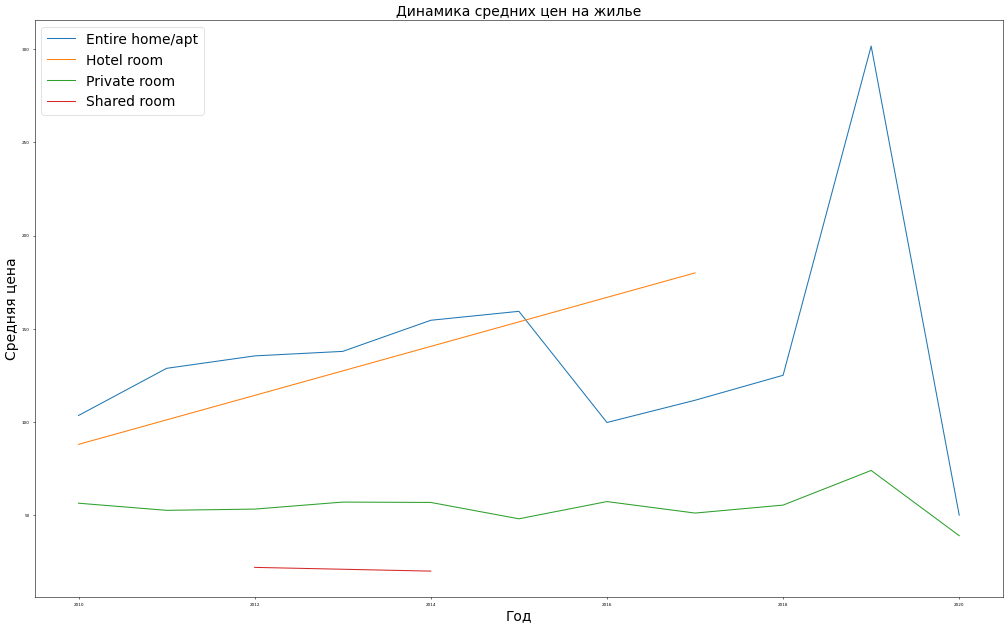

In [174]:
fig=plt.figure(figsize=(25,15), dpi=50)
sns.lineplot(data=q_lineplot, y='avg_price', x='first_review', hue='room_type')
plt.title('Динамика средних цен на жилье', size=20)
plt.xlabel('Год', size=20)
plt.ylabel('Средняя цена', size=20)
plt.rc('axes', labelsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.legend()
plt.show()